## FML 09
***

In [1]:
import numpy as np
import scipy as sp

from scipy.optimize import least_squares

import matplotlib.pyplot as plt
import pandas as pd

from krr import KernelRidge
from utils import (to_img, circle_from_points, refine_fit)
from viz import (plot_circles_and_data, plot_refined_circles)

%load_ext autoreload
%autoreload 2

### Kernalized Ridge Regression

In [2]:
img = plt.imread('cc_90.png')
img.shape

(338, 250)

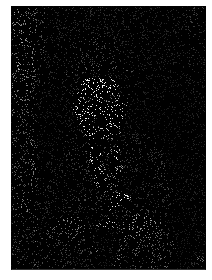

In [3]:
plt.figure(figsize=(4, 4))
plt.imshow(img, cmap='gray', interpolation='nearest', vmin=0, vmax=1)
plt.xticks([])
plt.yticks([])
plt.tight_layout()

In [4]:
data_set = np.indices(img.shape).reshape((2, -1)).T
output_set = img[data_set[:, 0], data_set[:, 1]]

In [5]:
X_train = data_set[output_set != 0]
y_train = output_set[output_set != 0]

X_test = data_set[output_set == 0]

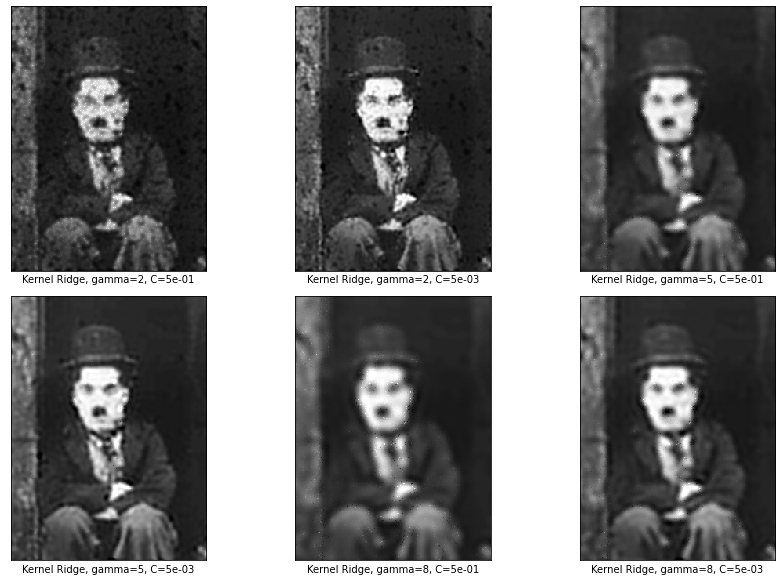

In [6]:
gamma_values = [2.5, 5., 7.5]
reg_values = [0.5, 0.005]

plot_number = 1
def add_subplot():
    global plot_number
    plt.subplot(3, 3, plot_number)
    plot_number += 1
    
plt.figure(figsize=(12, 12))
for gamma in gamma_values:
    for C in reg_values:
        add_subplot()
        krr_s_gaussian = KernelRidge(kernel_type='s_gaussian', C=C, gamma=gamma)
        krr_s_gaussian.fit(X_train, y_train, sparse=True)
        predictions = krr_s_gaussian.predict(X_train, X_test, sparse=True)
        
        plt.imshow(to_img(img, X_test, predictions), 
                   cmap='gray', 
                   interpolation='nearest', 
                   vmin=0, 
                   vmax=1)
        
        plt.xticks([])
        plt.yticks([])
        plt.xlabel('Kernel Ridge, gamma=%.0f, C=%.0e' % (gamma, C))
        
plt.tight_layout()        

In [7]:
rng = np.random.RandomState(0)

# Generate sample data
X_train = 15 * rng.rand(100, 1)
y_train = np.sin(X_train).ravel()
y_train += 3 * (0.5 - rng.rand(X_train.shape[0]))  # add noise

In [8]:
X_test = np.linspace(0, 20, 10000)[:, None]

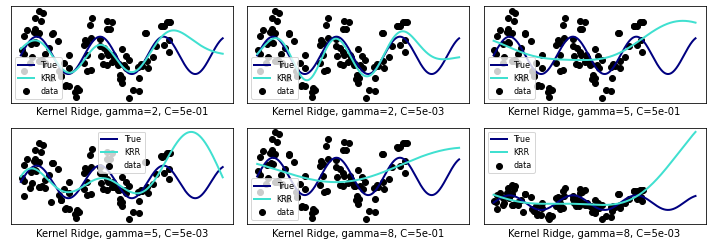

In [9]:
lw = 2
plt.figure(figsize=(10, 5))

plot_number = 1
for gamma in gamma_values:
    for C in reg_values:
        add_subplot()
        
        plt.scatter(X_train, y_train, c='k', label='data')
        plt.plot(X_test, np.sin(X_test), color='navy', lw=lw, label='True')
        
        krr_gaussian = KernelRidge(kernel_type='gaussian', C=C, gamma=gamma)
        krr_gaussian.fit(X_train, y_train)
        predictions = krr_gaussian.predict(X_train, X_test)
        plt.plot(X_test, predictions, color='turquoise', lw=lw, label='KRR')
        
        plt.xticks([])
        plt.yticks([])
        plt.xlabel('Kernel Ridge, gamma=%.0f, C=%.0e' % (gamma, C))
        plt.legend(loc="best",  scatterpoints=1, prop={'size': 8})

plt.tight_layout()

### RANSAC

In [10]:
data = np.load('circles.npy')

In [11]:
eps = 0.07
n_circles = 6
s = 3
model = []
for n in range(n_circles):
    # N = math.comb(data.shape[0], 3)  # Number of iterations
    N = int(1e4)
    MCS_idx = []  # Maximum Consensus Set
    CS_idx = []  # Consensus Set

    for i in range(N):
        
        # Draw subset containing s elements
        idxs = np.arange(data.shape[0], dtype=int)
        points = data[np.random.choice(idxs, s, replace=False)]
        
        # Calculate model
        c, r = circle_from_points(points)
        
        # Calculate distance from circle
        dist_from_circle = np.abs((data[:, 0] - c[0]) ** 2 + (data[:, 1] - c[1]) ** 2 - r ** 2)
        
        # Check if inlier
        CS_idx = np.where(dist_from_circle < eps ** 2)[0]
        CS_mask = dist_from_circle < eps ** 2
        
        card_CS = len(CS_idx)
        card_MCS = len(MCS_idx)

        if card_CS > card_MCS:
            MCS_idx = CS_idx
            MCS_mask = CS_mask
            # prob_inlier = card_CS / data.shape[0]
            
            # Update N
            # N = math.log((1 - (prob_inlier) ** s) ** N) / math.log((1 - (prob_inlier) ** s))
            
            r_MCS = r
            c_MCS = c
            
    MCS = data[MCS_idx]
    data = data[~MCS_mask]
    model.append({'r': r_MCS, 'c': c_MCS, 'MCS': MCS})

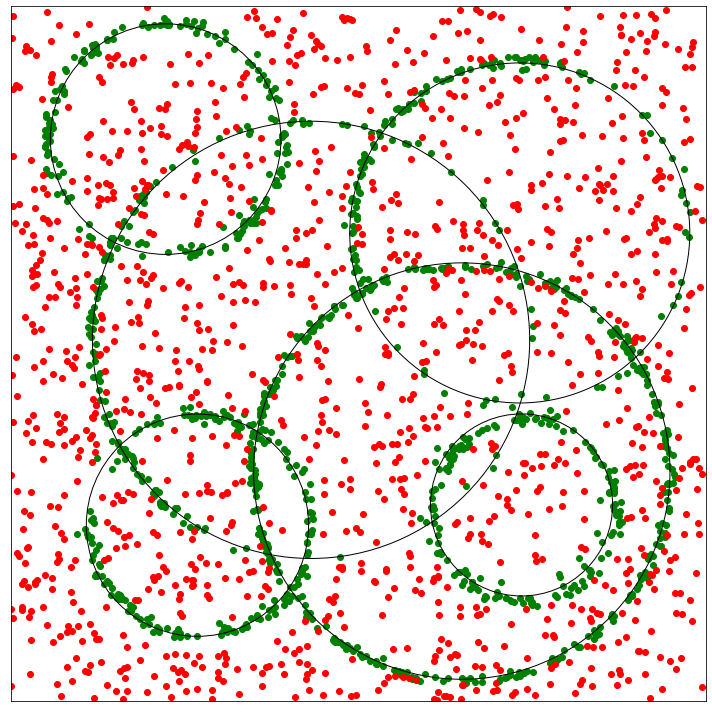

In [12]:
plot_circles_and_data(model, data)

### Algebraic Distance & Levenberg-Marquardt

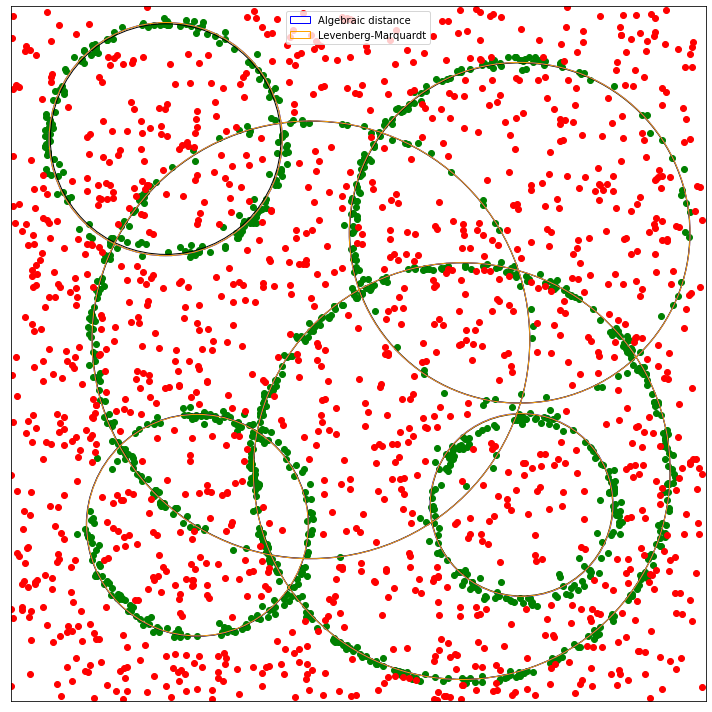

In [13]:
plot_circles_and_data(model, data)
plot_refined_circles(model) 